In [538]:
import json
import pickle
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as  plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'



# Data Understanding

## Сбор данных

In [4]:
# Заголовок и url для запроса к auto.ru
url = 'https://auto.ru/-/ajax/desktop/listing/'

header = '''Здесь должен находиться заголовок запроса скопированный из браузера.
            Удалил для конфиденциальности:)'''.strip().split('\n')

dict_header = {}

for el in header:
    key, value = el.split(': ')
    dict_header[key] = value

In [11]:
# Загрузка объявлений с 99-ти страниц
offers = []
for page in range(1, 100):
    params = {"moto_category":"MOTORCYCLE","section":"used","category":"moto", "page": page}
    response = requests.post(url, json=params, headers = dict_header)
    data = response.json()
    offers.extend(data['offers'])
    f'Load page: {data["pagination"]["page"]}'
    

'Load page: 1'

'Load page: 2'

'Load page: 3'

'Load page: 4'

'Load page: 5'

'Load page: 6'

'Load page: 7'

'Load page: 8'

'Load page: 9'

'Load page: 10'

'Load page: 11'

'Load page: 12'

'Load page: 13'

'Load page: 14'

'Load page: 15'

'Load page: 16'

'Load page: 17'

'Load page: 18'

'Load page: 19'

'Load page: 20'

'Load page: 21'

'Load page: 22'

'Load page: 23'

'Load page: 24'

'Load page: 25'

'Load page: 26'

'Load page: 27'

'Load page: 28'

'Load page: 29'

'Load page: 30'

'Load page: 31'

'Load page: 32'

'Load page: 33'

'Load page: 34'

'Load page: 35'

'Load page: 36'

'Load page: 37'

'Load page: 38'

'Load page: 39'

'Load page: 40'

'Load page: 41'

'Load page: 42'

'Load page: 43'

'Load page: 44'

'Load page: 45'

'Load page: 46'

'Load page: 47'

'Load page: 48'

'Load page: 49'

'Load page: 50'

'Load page: 51'

'Load page: 52'

'Load page: 53'

'Load page: 54'

'Load page: 55'

'Load page: 56'

'Load page: 57'

'Load page: 58'

'Load page: 59'

'Load page: 60'

'Load page: 61'

'Load page: 62'

'Load page: 63'

'Load page: 64'

'Load page: 65'

'Load page: 66'

'Load page: 67'

'Load page: 68'

'Load page: 69'

'Load page: 70'

'Load page: 71'

'Load page: 72'

'Load page: 73'

'Load page: 74'

'Load page: 75'

'Load page: 76'

'Load page: 77'

'Load page: 78'

'Load page: 79'

'Load page: 80'

'Load page: 81'

'Load page: 82'

'Load page: 83'

'Load page: 84'

'Load page: 85'

'Load page: 86'

'Load page: 87'

'Load page: 88'

'Load page: 89'

'Load page: 90'

'Load page: 91'

'Load page: 92'

'Load page: 93'

'Load page: 94'

'Load page: 95'

'Load page: 96'

'Load page: 97'

'Load page: 98'

'Load page: 99'

In [17]:
print(f'Количество объявлений: {len(offers)}')

Количество объявлений: 3663


In [18]:
# Сохраняем данные в json формат
with open('data/data.json', 'w', encoding='utf-8') as file:
    json.dump(offers, file)

## Отбор признаков и преобразование в DataFrame

In [19]:
# Создаем переменнные и сохраняем в них признаки
availability = []
owners_number = []
pts = []
custom_cleared = []
year = []
price = []
with_nds = []
is_oficial = []
city = []
parents_ids_len = []
mileage = []
state_not_beaten = []
images_count = []
cylinder_amount = []
cylinder_order = []
displacement = []
engine = []
gear = []
horse_power = []
mark = []
model_info = []
moto_type = []
stroke_amount = []
transmission = []
for offer in offers:
    availability.append(offer['availability'])
    d = offer['documents']
    owners_number.append(d.get('owners_number', np.NAN))
    pts.append(d.get('pts', np.NAN))
    custom_cleared.append(d.get('custom_cleared', np.NAN))
    year.append(d['year'])
    price.append(offer['price_info']['price'])
    with_nds.append(offer['price_info']['with_nds'])
    is_oficial.append(offer['salon']['is_oficial'])
    city.append(offer['seller']['location']['region_info']['name'])
    parents_ids_len.append(len(offer['seller']['location']['region_info']['parent_ids']))
    st = offer['state']
    mileage.append(st['mileage'])
    state_not_beaten.append(st['state_not_beaten'])
    images_count.append(st['images_count'])
    v_i = offer['vehicle_info']
    cylinder_amount.append(v_i.get('cylinder_amount', np.NAN))
    cylinder_order.append(v_i.get('cylinder_order', np.NAN))
    displacement.append(v_i['displacement'])
    engine.append(v_i.get('engine', np.NAN))
    gear.append(v_i.get('gear', 'Not_info'))
    horse_power.append(v_i.get('horse_power', np.NAN))
    mark.append(v_i['mark_info']['name'])
    model_info.append(v_i['model_info']['code'])
    moto_type.append(v_i.get('moto_type', np.NAN))
    stroke_amount.append(v_i.get('stroke_amount', np.NAN))
    transmission.append(v_i.get('transmission', np.NAN))

In [25]:
# Создаем дата-фрейм
columns = ['availability', 'owners_number', 'pts', 'custom_cleared', 'year',
       'price', 'with_nds', 'is_oficial', 'city', 'parents_ids_len', 'mileage',
       'state_not_beaten', 'images_count', 'cylinder_amount', 'cylinder_order',
       'displacement', 'engine', 'gear', 'horse_power', 'mark', 'model_info',
       'moto_type', 'stroke_amount', 'transmission']
all_data = [availability, owners_number, pts, custom_cleared, year,
       price, with_nds, is_oficial, city, parents_ids_len, mileage,
       state_not_beaten, images_count, cylinder_amount, cylinder_order,
       displacement, engine, gear, horse_power, mark, model_info,
       moto_type, stroke_amount, transmission]
df = pd.DataFrame(index=range(len(offers)))
for i in range(len(columns)):
    df[columns[i]] = all_data[i]
df.head()

,availability,owners_number,pts,custom_cleared,year,price,with_nds,is_oficial,city,parents_ids_len,mileage,state_not_beaten,images_count,cylinder_amount,cylinder_order,displacement,engine,gear,horse_power,mark,model_info,moto_type,stroke_amount,transmission
0,IN_STOCK,1,ORIGINAL,True,2006,598000,False,False,Домодедово,7,24237,True,15,CYLINDERS_2,V_TYPE,1312,CARBURETOR,CARDAN,75.0,Honda,VTX1300,CRUISER,STROKES_4,TRANSMISSION_5
1,IN_STOCK,1,ORIGINAL,True,2021,2390000,False,False,Копейск,7,3900,True,19,CYLINDERS_4,LINE,1000,INJECTOR,CHAIN,165.0,BMW,S_1000_R,NAKEDBIKE,STROKES_4,TRANSMISSION_6
2,IN_STOCK,1,ORIGINAL,True,2021,4100000,True,True,Казань,7,5753,True,15,CYLINDERS_2,V_TYPE,1868,INJECTOR,BELT,93.0,Harley-Davidson,ULTRA_LIMITED,CRUISER,STROKES_4,TRANSMISSION_6
3,IN_STOCK,2,ORIGINAL,True,2021,1500000,False,False,Москва,6,9000,True,12,CYLINDERS_4,LINE,948,INJECTOR,CHAIN,125.0,Kawasaki,Z_900,NAKEDBIKE,STROKES_4,TRANSMISSION_6
4,IN_STOCK,3,ORIGINAL,True,2019,1748000,False,True,Москва,6,568,True,6,CYLINDERS_2,OPPOSITE,1200,INJECTOR,CARDAN,110.0,BMW,R_NINE_T_PURE,CUSTOM,STROKES_4,TRANSMISSION_6


## Изучение данных

In [31]:
# Выводим тип переменных
df.dtypes

availability         object
owners_number         int64
pts                  object
custom_cleared       object
year                  int64
price                 int64
with_nds               bool
is_oficial             bool
city                 object
parents_ids_len       int64
mileage               int64
state_not_beaten       bool
images_count          int64
cylinder_amount      object
cylinder_order       object
displacement          int64
engine               object
gear                 object
horse_power         float64
mark                 object
model_info           object
moto_type            object
stroke_amount        object
transmission         object
dtype: object

In [32]:
# Выводим описательные статистики 
df.describe()

,owners_number,year,price,parents_ids_len,mileage,images_count,displacement,horse_power
count,3663.00000,3663.000000,3.663000e+03,3663.000000,3663.000000,3663.000000,3663.000000,2842.000000
mean,1.54136,2010.565384,8.671709e+05,6.464100,27371.536719,11.318318,989.155883,91.301900
std,0.86807,7.786650,7.892982e+05,0.598795,25870.358972,6.913779,2168.092926,44.452637
min,1.00000,1892.000000,1.100000e+04,5.000000,1.000000,1.000000,1.000000,2.000000
25%,1.00000,2006.000000,4.200000e+05,6.000000,8000.000000,6.000000,650.000000,55.000000
50%,1.00000,2012.000000,6.450000e+05,6.000000,21837.000000,10.000000,895.000000,92.000000
75%,2.00000,2016.000000,9.990000e+05,7.000000,40098.500000,15.000000,1200.000000,120.000000
max,4.00000,2022.000000,9.500000e+06,9.000000,561219.000000,40.000000,99999.000000,350.000000


In [33]:
# Выводим статистики для категориальных признаков
df.describe(include=object)

,availability,pts,custom_cleared,city,cylinder_amount,cylinder_order,engine,gear,mark,model_info,moto_type,stroke_amount,transmission
count,3663,3663,3604,3663,2542,2201,3176,3663,3663,3663,3428,2343,2994
unique,1,2,1,354,6,4,3,4,84,727,22,2,14
top,IN_STOCK,ORIGINAL,True,Москва,CYLINDERS_2,LINE,INJECTOR,CHAIN,Honda,R_1200_GS,ROAD,STROKES_4,TRANSMISSION_6
freq,3663,3563,3604,1674,1393,1002,2521,1841,733,59,482,2295,1948


In [36]:
# Видим что есть фичи которые имеют лишь одно значение
df.availability.value_counts(dropna=False), df.custom_cleared.value_counts(dropna=False)

(IN_STOCK    3663
 Name: availability, dtype: int64,
 True    3604
 NaN       59
 Name: custom_cleared, dtype: int64)

In [37]:
# Удалим их
df.drop(['availability', 'custom_cleared'], axis=1, inplace=True)

In [38]:
# Сохраним датафрейм
df.to_csv('data/data_all.csv', index=False)

# Data Preparation

In [180]:
df = pd.read_csv('data/data_all.csv')
df.head()

,owners_number,pts,year,price,with_nds,is_oficial,city,parents_ids_len,mileage,state_not_beaten,images_count,cylinder_amount,cylinder_order,displacement,engine,gear,horse_power,mark,model_info,moto_type,stroke_amount,transmission
0,1,ORIGINAL,2006,598000,False,False,Домодедово,7,24237,True,15,CYLINDERS_2,V_TYPE,1312,CARBURETOR,CARDAN,75.0,Honda,VTX1300,CRUISER,STROKES_4,TRANSMISSION_5
1,1,ORIGINAL,2021,2390000,False,False,Копейск,7,3900,True,19,CYLINDERS_4,LINE,1000,INJECTOR,CHAIN,165.0,BMW,S_1000_R,NAKEDBIKE,STROKES_4,TRANSMISSION_6
2,1,ORIGINAL,2021,4100000,True,True,Казань,7,5753,True,15,CYLINDERS_2,V_TYPE,1868,INJECTOR,BELT,93.0,Harley-Davidson,ULTRA_LIMITED,CRUISER,STROKES_4,TRANSMISSION_6
3,2,ORIGINAL,2021,1500000,False,False,Москва,6,9000,True,12,CYLINDERS_4,LINE,948,INJECTOR,CHAIN,125.0,Kawasaki,Z_900,NAKEDBIKE,STROKES_4,TRANSMISSION_6
4,3,ORIGINAL,2019,1748000,False,True,Москва,6,568,True,6,CYLINDERS_2,OPPOSITE,1200,INJECTOR,CARDAN,110.0,BMW,R_NINE_T_PURE,CUSTOM,STROKES_4,TRANSMISSION_6


## Заполнение пропусков в данных

In [181]:
# Смотрим количество пропусков
df.isnull().sum()

owners_number          0
pts                    0
year                   0
price                  0
with_nds               0
is_oficial             0
city                   0
parents_ids_len        0
mileage                0
state_not_beaten       0
images_count           0
cylinder_amount     1121
cylinder_order      1462
displacement           0
engine               487
gear                   0
horse_power          821
mark                   0
model_info             0
moto_type            235
stroke_amount       1320
transmission         669
dtype: int64

In [182]:
miss_col = ['cylinder_amount', 'cylinder_order', 'engine', 'horse_power',
            'moto_type', 'stroke_amount', 'transmission']

In [183]:
df.model_info.nunique()

727

In [184]:
'''Т.к все пропуски находятся в переменных которые характеризуют двигатель мотоцикла,
можно предположить если модели мотоцикла одинаковые, то характеристики двигателя должны совпадать'''

# Модели которые встречаются минимум 2 раза в датасете
model_names = df.model_info.value_counts()[df.model_info.value_counts() > 1].index
# Проходимся по всем фичам
for c in miss_col:
    # Проходимся по всем моделям и находим для каждой модели значение которым заменяем пропуски
    for model in model_names:
        # Оборачиваем все в try-except, 
        # потому что может случиться так что для определенной модели все значения будут nan
        # и возникнет ошибка
        try:
            # В качестве значения для horse_power берем медиану, для всех остальных моду
            if c == 'horse_power':
                value = df[df.model_info == model][c].median()
            else:
                value = df[df.model_info == model][c].mode()[0]

            df[c][(df.model_info == model) & (df[c].isna())] = value
        except:
            pass
  

'Т.к все пропуски находятся в переменных которые характеризуют двигатель мотоцикла,\nможно предположить если модели мотоцикла одинаковые, то характеристики двигателя должны совпадать'

C:\Users\Artem\AppData\Local\Temp/ipykernel_6280/1673444382.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c][(df.model_info == model) & (df[c].isna())] = value


In [185]:
# Смотрим что пропусков стало меньше
df.isnull().sum()

owners_number         0
pts                   0
year                  0
price                 0
with_nds              0
is_oficial            0
city                  0
parents_ids_len       0
mileage               0
state_not_beaten      0
images_count          0
cylinder_amount     104
cylinder_order      222
displacement          0
engine               44
gear                  0
horse_power          87
mark                  0
model_info            0
moto_type            19
stroke_amount       126
transmission         81
dtype: int64

In [186]:
len(df), len(df.dropna())  

(3663, 3353)

In [188]:
# Удалим строки с пропусками
df_prep = df.dropna()
df_prep.shape

(3353, 22)

## Работа с выбросами

In [358]:
# Фичи у которых могут быть выбросы
numerical_col = ['year', 'price', 'mileage', 'displacement', 'horse_power']
numerical_col

['year', 'price', 'mileage', 'displacement', 'horse_power']

<AxesSubplot:title={'center':'Boxplot year'}>

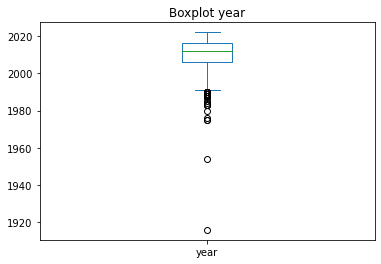

<AxesSubplot:title={'center':'Boxplot price'}>

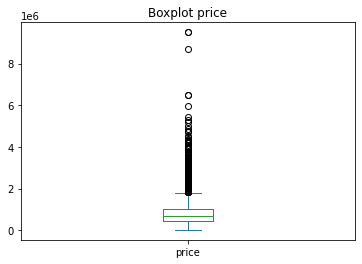

<AxesSubplot:title={'center':'Boxplot mileage'}>

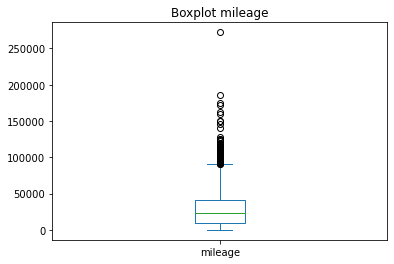

<AxesSubplot:title={'center':'Boxplot displacement'}>

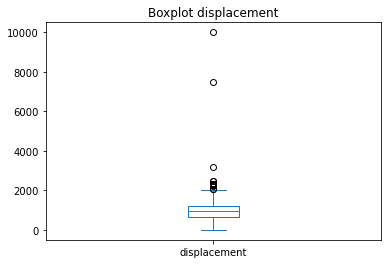

<AxesSubplot:title={'center':'Boxplot horse_power'}>

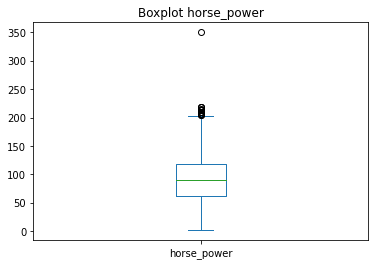

In [190]:
# Смотрим на график боксплот
for c in numerical_col:
    df_prep[c].plot(kind='box', title=f'Boxplot {c}')
    plt.show();

In [191]:
# Есть два варианта, что делать с выбросами: 
# Удалить строки с выбросами(Данных и так мало), либо заменить их граничными значениями
# Сделаю оба варианта и сравню качество предсказаний
bounds_all = []
df_prep_vbr = df_prep.copy()
for c in numerical_col:
    q75 = df_prep[c].quantile(0.75)
    q25 =  df_prep[c].quantile(0.25)
    intr = q75 - q25
    bounds = (q25 - intr * 1.5), (q75 + intr * 1.5)
    bounds_all.append(bounds)
    df_prep_vbr[c][df_prep_vbr[c] < bounds[0]] = bounds[0]
    df_prep_vbr[c][df_prep_vbr[c] > bounds[1]] = bounds[1]
    df_prep = df_prep[(df_prep[c] >= bounds[0]) & (df_prep[c] <= bounds[1])]

C:\Users\Artem\AppData\Local\Temp/ipykernel_6280/2287736494.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep_vbr[c][df_prep_vbr[c] < bounds[0]] = bounds[0]
C:\Users\Artem\AppData\Local\Temp/ipykernel_6280/2287736494.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep_vbr[c][df_prep_vbr[c] > bounds[1]] = bounds[1]
C:\Users\Artem\AppData\Local\Temp/ipykernel_6280/2287736494.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [193]:
for c in range(len(bounds_all)):
    print(f'{numerical_col[c]} df_prep_vbr: {len(df_prep_vbr[(df_prep_vbr[numerical_col[c]] < bounds_all[c][0]) | (df_prep_vbr[numerical_col[c]] > bounds_all[c][1])])}')
    print(f'{numerical_col[c]} df_prep: {len(df_prep[(df_prep[numerical_col[c]] < bounds_all[c][0]) | (df_prep[numerical_col[c]] > bounds_all[c][1])])}')

year df_prep_vbr: 0
year df_prep: 0
price df_prep_vbr: 0
price df_prep: 0
mileage df_prep_vbr: 0
mileage df_prep: 0
displacement df_prep_vbr: 0
displacement df_prep: 0
horse_power df_prep_vbr: 0
horse_power df_prep: 0


In [195]:
# Проверяем остальные чиловые признаки
df_prep.owners_number.value_counts(), df_prep.parents_ids_len.value_counts(),df_prep.images_count.value_counts()

(1    1905
 2     512
 3     360
 4     153
 Name: owners_number, dtype: int64,
 6    1761
 7    1017
 8     135
 5       9
 9       8
 Name: parents_ids_len, dtype: int64,
 11    351
 6     232
 5     220
 8     215
 7     198
      ... 
 39      3
 37      3
 34      3
 38      3
 35      1
 Name: images_count, Length: 40, dtype: int64)

In [196]:
# Заменяем выбросы у images_count
q75 = df_prep.images_count.quantile(0.75)
q25 =  df_prep.images_count.quantile(0.25)
intr = q75 - q25
bounds = (q25 - intr * 1.5), (q75 + intr * 1.5)
df_prep_vbr.images_count[df_prep_vbr.images_count < bounds[0]] = bounds[0]
df_prep_vbr.images_count[df_prep_vbr.images_count > bounds[1]] = bounds[1]
df_prep.images_count[df_prep.images_count < bounds[0]] = bounds[0]
df_prep.images_count[df_prep.images_count > bounds[1]] = bounds[1]

C:\Users\Artem\AppData\Local\Temp/ipykernel_6280/1563837761.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep_vbr.images_count[df_prep_vbr.images_count < bounds[0]] = bounds[0]
C:\Users\Artem\AppData\Local\Temp/ipykernel_6280/1563837761.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep_vbr.images_count[df_prep_vbr.images_count > bounds[1]] = bounds[1]
C:\Users\Artem\AppData\Local\Temp/ipykernel_6280/1563837761.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [197]:
# Убедимся что все отработало правильно
df_prep.images_count.value_counts()

11.0    351
6.0     232
5.0     220
8.0     215
7.0     198
10.0    183
9.0     146
4.0     145
13.0    125
3.0      97
28.5     96
12.0     96
20.0     96
14.0     87
18.0     81
15.0     74
16.0     69
19.0     66
17.0     64
1.0      47
21.0     44
2.0      41
22.0     29
25.0     27
23.0     26
28.0     21
27.0     18
24.0     18
26.0     18
Name: images_count, dtype: int64

## Проверяем дубликаты в данных

In [200]:
sum(df_prep.duplicated()), sum(df_prep_vbr.duplicated())

(16, 19)

In [201]:
df_prep.drop_duplicates(inplace=True)
df_prep_vbr.drop_duplicates(inplace=True)
df_prep.shape, df_prep_vbr.shape

((2914, 22), (3334, 22))

In [202]:
sum(df_prep.duplicated()), sum(df_prep_vbr.duplicated())

(0, 0)

In [203]:
# Сохраняем датафреймы
df_prep.to_csv('data/df_prep.csv', index=False)
df_prep_vbr.to_csv('data/df_prep_vbr.csv', index=False)

# Modeling

In [504]:
df_prep = pd.read_csv('data/df_prep.csv')
df_prep_vbr = pd.read_csv('data/df_prep_vbr.csv')
df_prep.shape, df_prep_vbr.shape

((2914, 22), (3334, 22))

## Построение первой модели и выбор датасета 

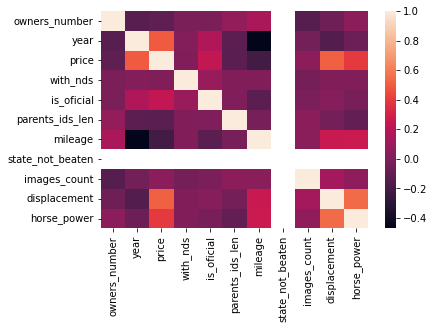

In [505]:
# Смотрим корреляцию
sns.heatmap(df_prep.corr());

In [506]:
# Удалим признак state_not_beaten, т.к он имеют одно значение
df_prep.drop('state_not_beaten', axis=1, inplace=True)
df_prep_vbr.drop('state_not_beaten', axis=1, inplace=True)

In [507]:
# Нет большой корреляции между таргетом и предикторами, но также нет и мультиколлинеарности что хорошо
df_prep_vbr.corr()[df_prep_vbr.corr() > 0.5]

,owners_number,year,price,with_nds,is_oficial,parents_ids_len,mileage,images_count,displacement,horse_power
owners_number,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,1.000000,0.573799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,NaN,0.573799,1.000000,NaN,NaN,NaN,NaN,NaN,0.587763,NaN
with_nds,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
is_oficial,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
parents_ids_len,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
mileage,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
images_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
displacement,NaN,NaN,0.587763,NaN,NaN,NaN,NaN,NaN,1.000000,0.514093
horse_power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.514093,1.000000


In [508]:
normalize_col = ['year', 'mileage', 'displacement', 'horse_power']
normalize_col

['year', 'mileage', 'displacement', 'horse_power']

In [509]:
# Обучаем разные модели и выбираем датасет
def learn_model(data, model):
    data = pd.get_dummies(data)
    scaler = StandardScaler().fit(data[normalize_col])
    data[normalize_col] = scaler.transform(data[normalize_col])
    X = data.drop('price', axis=1)
    y = data.price

    print(f'Model: {str(model)}\n')
    print('Cross score:')
    cross_score = cross_val_score(model, X=X, y=y, cv=10, n_jobs=-1)
    print(f'Mean: {cross_score.mean()}')
    print(f'Std: {cross_score.std()}\n')


In [510]:
models = [RandomForestRegressor(random_state=42), Ridge(), Lasso()]
for model in models:
    learn_model(df_prep, model)

Model: RandomForestRegressor(random_state=42)

Cross score:
Mean: 0.8164988388740799
Std: 0.03347097637745809

Model: Ridge()

Cross score:
Mean: 0.7900752498035369
Std: 0.03813172636080411

Model: Lasso()

Cross score:
Mean: 0.7581040873913862
Std: 0.05297828681289475



In [511]:
models = [RandomForestRegressor(random_state=42), Ridge(), Lasso()]
for model in models:
    learn_model(df_prep_vbr, model)

Model: RandomForestRegressor(random_state=42)

Cross score:
Mean: 0.8684898415751476
Std: 0.031246630479028596

Model: Ridge()

Cross score:
Mean: 0.8381229253543692
Std: 0.03958090177721107

Model: Lasso()

Cross score:
Mean: 0.8162877490900607
Std: 0.052891985092235194



Видим что качество получилось лучше на датафрейме в котором выбросы были заменены
крайними значениями, значит оставляем df_prep_vbr

## Отбор признаков

In [ ]:
# Кодируем категориальные переменные
df_prep_vbr = pd.get_dummies(df_prep_vbr)

# Нормализуем числовые предикторы
scaler = StandardScaler().fit(df_prep_vbr[normalize_col])
df_prep_vbr[normalize_col] = scaler.transform(df_prep_vbr[normalize_col])

df_prep_vbr.head()

In [513]:
# Данных мало, будем использовать кросс-валидацию, без тестовой выборки, поэтому просто делим на X и y
X = df_prep_vbr.drop('price', axis=1)
y = df_prep_vbr.price

In [514]:
# Попробуем использовать Lasso для отбора фичей
params_lasso = {'alpha': [9, 19, 29, 56]}
grid_lasso = GridSearchCV(Lasso(), param_grid=params_lasso, cv=5, verbose=True, n_jobs=-1)
grid_lasso.fit(X, y)
grid_lasso.score(X, y), grid_lasso.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [9, 19, 29, 56]}, verbose=True)

(0.9053911362426825, {'alpha': 56})

In [515]:
best_lasso = grid_lasso.best_estimator_
cross_score_lasso = cross_val_score(best_lasso, X=X, y=y, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')
cross_score_lasso.mean(), cross_score_lasso.std()

(-138669.2144102025, 8865.376901291991)

In [516]:
features_importance = pd.DataFrame({'name': X.columns, 'importance': np.abs(best_lasso.coef_)})
features_importance.sort_values('importance', ascending=False).head(10)

,name,importance
303,city_Феодосия,783344.746091
367,mark_Harley-Davidson,619276.545876
797,model_info_VALKIRIE_1800,601253.354069
58,city_Волжский,558632.724786
428,model_info_3_112,553693.102426
373,mark_Indian,522425.129897
486,model_info_CBR_650_R,521186.080801
614,model_info_HP2_MEGAMOTO,506738.685018
375,mark_Jawa,506422.936943
756,model_info_STREET,502898.364265


In [517]:
sum(features_importance.importance == 0) # Смотрим количество фичей с нулевыми коэффициентами

412

In [518]:
# Удалим эти фичи
not_importance = features_importance[features_importance.importance == 0].name.values
X.drop(not_importance, axis=1, inplace=True)
X.shape

(3334, 538)

In [528]:
# Переобучаем модель и смотрим качество
params_lasso = {'alpha': np.arange(20, 24, 0.2)}
grid_lasso = GridSearchCV(Lasso(), param_grid=params_lasso, cv=5, verbose=True, n_jobs=-1)
grid_lasso.fit(X, y)
grid_lasso.score(X, y), grid_lasso.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4, 21.6, 21.8, 22. ,
       22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6, 23.8])},
             verbose=True)

(0.9124597580494236, {'alpha': 22.39999999999999})

In [529]:
best_lasso = grid_lasso.best_estimator_
cross_score_lasso = cross_val_score(best_lasso, X=X, y=y, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')
cross_score_lasso.mean(), cross_score_lasso.std()

(-134246.37567629473, 7901.116488433167)

Качество даже улучшилось, значит все сделали верно

## Построение финальной модели и её оценка

In [531]:
# Также обучим RandomForest и Ridge чтобы сравнить и выбрать финальную модель

# Ищем лучшие гиперпараметры для Random Forest
params_forest = {'n_estimators':[50, 100, 150, 200, 250], 'criterion': ["mse", "mae"], 
                 'max_depth': range(1, 15, 2), 'max_features': range(50, 500, 50)}
grid_forest = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=params_forest, cv=5, verbose=True, random_state=42, n_jobs=-1)
grid_forest.fit(X, y)
grid_forest.score(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': range(1, 15, 2),
                                        'max_features': range(50, 500, 50),
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   random_state=42, verbose=True)

0.9592601179079132

In [532]:
# Смотрим MAE на кросс-валидации(Random Forest)
best_forest = grid_forest.best_estimator_
cross_score_forest = cross_val_score(best_forest, X=X, y=y, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')
cross_score_forest.mean(), cross_score_forest.std()

(-114385.91569735641, 10618.762786489388)

In [533]:
# Ищем лучшие гиперпараметры для Ridge
params_ridge = {'alpha': np.arange(0.2, 10, 0.2)}
grid_ridge = GridSearchCV(Ridge(), param_grid=params_ridge, cv=5, verbose=True, n_jobs=-1)
grid_ridge.fit(X, y)
grid_ridge.score(X, y), grid_ridge.best_params_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
       2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2,
       5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6, 7.8,
       8. , 8.2, 8.4, 8.6, 8.8, 9. , 9.2, 9.4, 9.6, 9.8])},
             verbose=True)

(0.9094703362657366, {'alpha': 0.6000000000000001})

In [534]:
# Смотрим MAE на кросс-валидации(Ridge)
best_ridge = grid_ridge.best_estimator_
cross_score_ridge = cross_val_score(best_ridge, X=X, y=y, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')
cross_score_ridge.mean(), cross_score_ridge.std()

(-132512.5146465097, 7716.435008925618)

In [537]:
# Разброс цены
df_prep_vbr.price.min(), df_prep_vbr.price.max()

(15000, 1862500)

У Случайного Леса получается лучшая средняя оценка на кросс-валидации - 114т.р, а стандартное отклонение 10т.р что хуже чем у линейной регрессии но не намного. Выбираю Случайный Лес.

Финальная оценка MAE:  114т.р при разбросе цены 1800т.р

## Сохранение результатов

In [539]:
# Сохраняем модель
with open('data/RandFor.pickle', 'wb') as file:
    pickle.dump(best_forest, file)

In [541]:
# Сохраняем обучающие данные
X.to_csv('data/X.csv', index=False)
y.to_csv('data/y.csv', index=False)

In [542]:
# Сохраняем Scaler
with open('data/scale.pickle', 'wb') as file:
    pickle.dump(scaler, file)